In [2]:
import pandas as pd 
import numpy as np
import re
import string
import nltk
from string import digits
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer 
from wordcloud import WordCloud
#from sklearn.naive_bayes import MultinomialNB  Possível modelo para análise futura
from sklearn.feature_extraction.text import TfidfVectorizer 
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [3]:
dados_treino = pd.read_csv('train.csv')
dados_teste = pd.read_csv('test.csv')

In [4]:
x_treino = dados_treino['comment_text']
y_treino= dados_treino[['toxic','severe_toxic','obscene','threat','insult','identity_hate' ]]
x_teste =  dados_teste['comment_text']

O código a seguir é responsável por processar todas as palavras do texto (após certo tratamento), classificá-las em substantivo, verbo, adjetivo e adverbio para que em seguida a função `Lemmatizer`consigua adequadamente transformar cada palavra em sua forma base. Essa pré classificação é importante pois um dos argumentos principais da função lemmatizer é o tipo de palavra que se deseja passar para a forma base.

Apesar de ser um algoritimo que garante uma boa acurácia na hora de transformar as palavras em sua forma base, ele exige um alto poder de processamento o que acaba tornando o processo bem lento na maioria dos computadores. Dessa forma, como iteração futura pretendemos analisar o quão necessário é adoção dele em nosso código, comparando a acurácia na previsão com e sem ele.

In [5]:
lemmatizer = WordNetLemmatizer()
stop = set(stopwords.words("english"))
wordnet_map = {"N":wordnet.NOUN, "V":wordnet.VERB, "J":wordnet.ADJ, "R":wordnet.ADV}
def lemmatize_words(text):
    pos_tagged_text = nltk.pos_tag(text)
    return [lemmatizer.lemmatize(word, wordnet_map.get(pos[0], wordnet.NOUN)) for word, pos in pos_tagged_text]

Como uma primeira análise optamos por averiguar apenas a influência de palavras no tipo de comentário no qual elas se inserem. Mais adiante, pretendemos aplicar o chamado 'feature engineering' para compreender correlações entre pontuações, letras maisculas, tamanho da sentença, dentro outros com a toxicidade do comentário.

In [6]:
x_treino.drop_duplicates()
x_teste.drop_duplicates()
def pre_processamento(texto):
    texto=texto.str.translate(str.maketrans(' ', ' ', string.punctuation))
    texto=texto.str.translate(str.maketrans(' ', ' ', '\n'))
    texto=texto.str.translate(str.maketrans(' ', ' ', digits))
    texto=texto.apply(lambda tweet: re.sub(r'([a-z])([A-Z])',r'\1 \2',tweet))
    texto=texto.str.lower()
    texto=texto.str.split()                                                                
    texto = texto.apply(lambda text: lemmatize_words(text))
    texto = texto.apply(lambda x: ' '.join(x))                                                                                         #Passando palavras para a forma base
    return texto


## Detalhando funções de pré-processamento
`lower` - Simplismente transforma tudo em letras minúsculas

`translate()` - O método retorna uma string com alguns caracteres substituidos por caracteres descritos em um 'mapping table'. 

Nesse caso essa mapping table é criada com `.maketrans()` que indica nessa ordem: string com caracteres a substituir, string com caracteres substitutos e caracteres a serem removidos.

    Source : https://www.w3schools.com/python/ref_string_maketrans.asp
`apply`- Aplica uma funçao ao longo de um eixo no dataframe. Nesse caso estamos usando em uma função `lambda` uma 'expressão recorrente' para a substituição de palavras juntas pelas mesmas separadas.

`lower` - simplismente transforma as letras em minúsculas
`split` - separando a string em palavras separadas com vírgula

`lemmatizewords` objeto criado com a função de transforma as palavras em sua forma base.

## Substituindo textos do DataFrame pelos texto tratados no pré-processamento

In [17]:
dados_treino['comment_text'] = pre_processamento(x_treino)
dados_treino

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,explanation why the edits make under my userna...,0,0,0,0,0,0
1,000103f0d9cfb60f,daww he match this background colour im seemin...,0,0,0,0,0,0
2,000113f07ec002fd,hey man im really not try to edit war it just ...,0,0,0,0,0,0
3,0001b41b1c6bb37e,more i cant make any real suggestion on improv...,0,0,0,0,0,0
4,0001d958c54c6e35,you sir be my hero any chance you remember wha...,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,and for the second time of ask when your view ...,0,0,0,0,0,0
159567,ffea4adeee384e90,you should be ashamed of yourself that be a ho...,0,0,0,0,0,0
159568,ffee36eab5c267c9,spitzer umm theres no actual article for prost...,0,0,0,0,0,0
159569,fff125370e4aaaf3,and it look like it be actually you who put on...,0,0,0,0,0,0


In [19]:
x_treino = dados_treino['comment_text']
x_treino

0         explanation why the edits make under my userna...
1         daww he match this background colour im seemin...
2         hey man im really not try to edit war it just ...
3         more i cant make any real suggestion on improv...
4         you sir be my hero any chance you remember wha...
                                ...                        
159566    and for the second time of ask when your view ...
159567    you should be ashamed of yourself that be a ho...
159568    spitzer umm theres no actual article for prost...
159569    and it look like it be actually you who put on...
159570    and i really dont think you understand i come ...
Name: comment_text, Length: 159571, dtype: object

In [18]:
dados_teste= pre_processamento(x_teste)
dados_teste

0         yo bitch ja rule be more succesful then youll ...
1                   from rf c the title be fine a it be imo
2                           source zawe ashton on lapland —
3         if you have a look back at the source the info...
4                    i dont anonymously edit article at all
                                ...                        
153159    i totally agree this stuff be nothing but tool...
153160    throw from out field to home plate do it get t...
153161    okinotorishima category i see your change and ...
153162    one of the founding nation of the eu germany h...
153163    stop already your bullshit be not welcome here...
Name: comment_text, Length: 153164, dtype: object

## WordCloud para vizualização das palavras mais frequentes em cada tipo de comentário após o pré-processamento

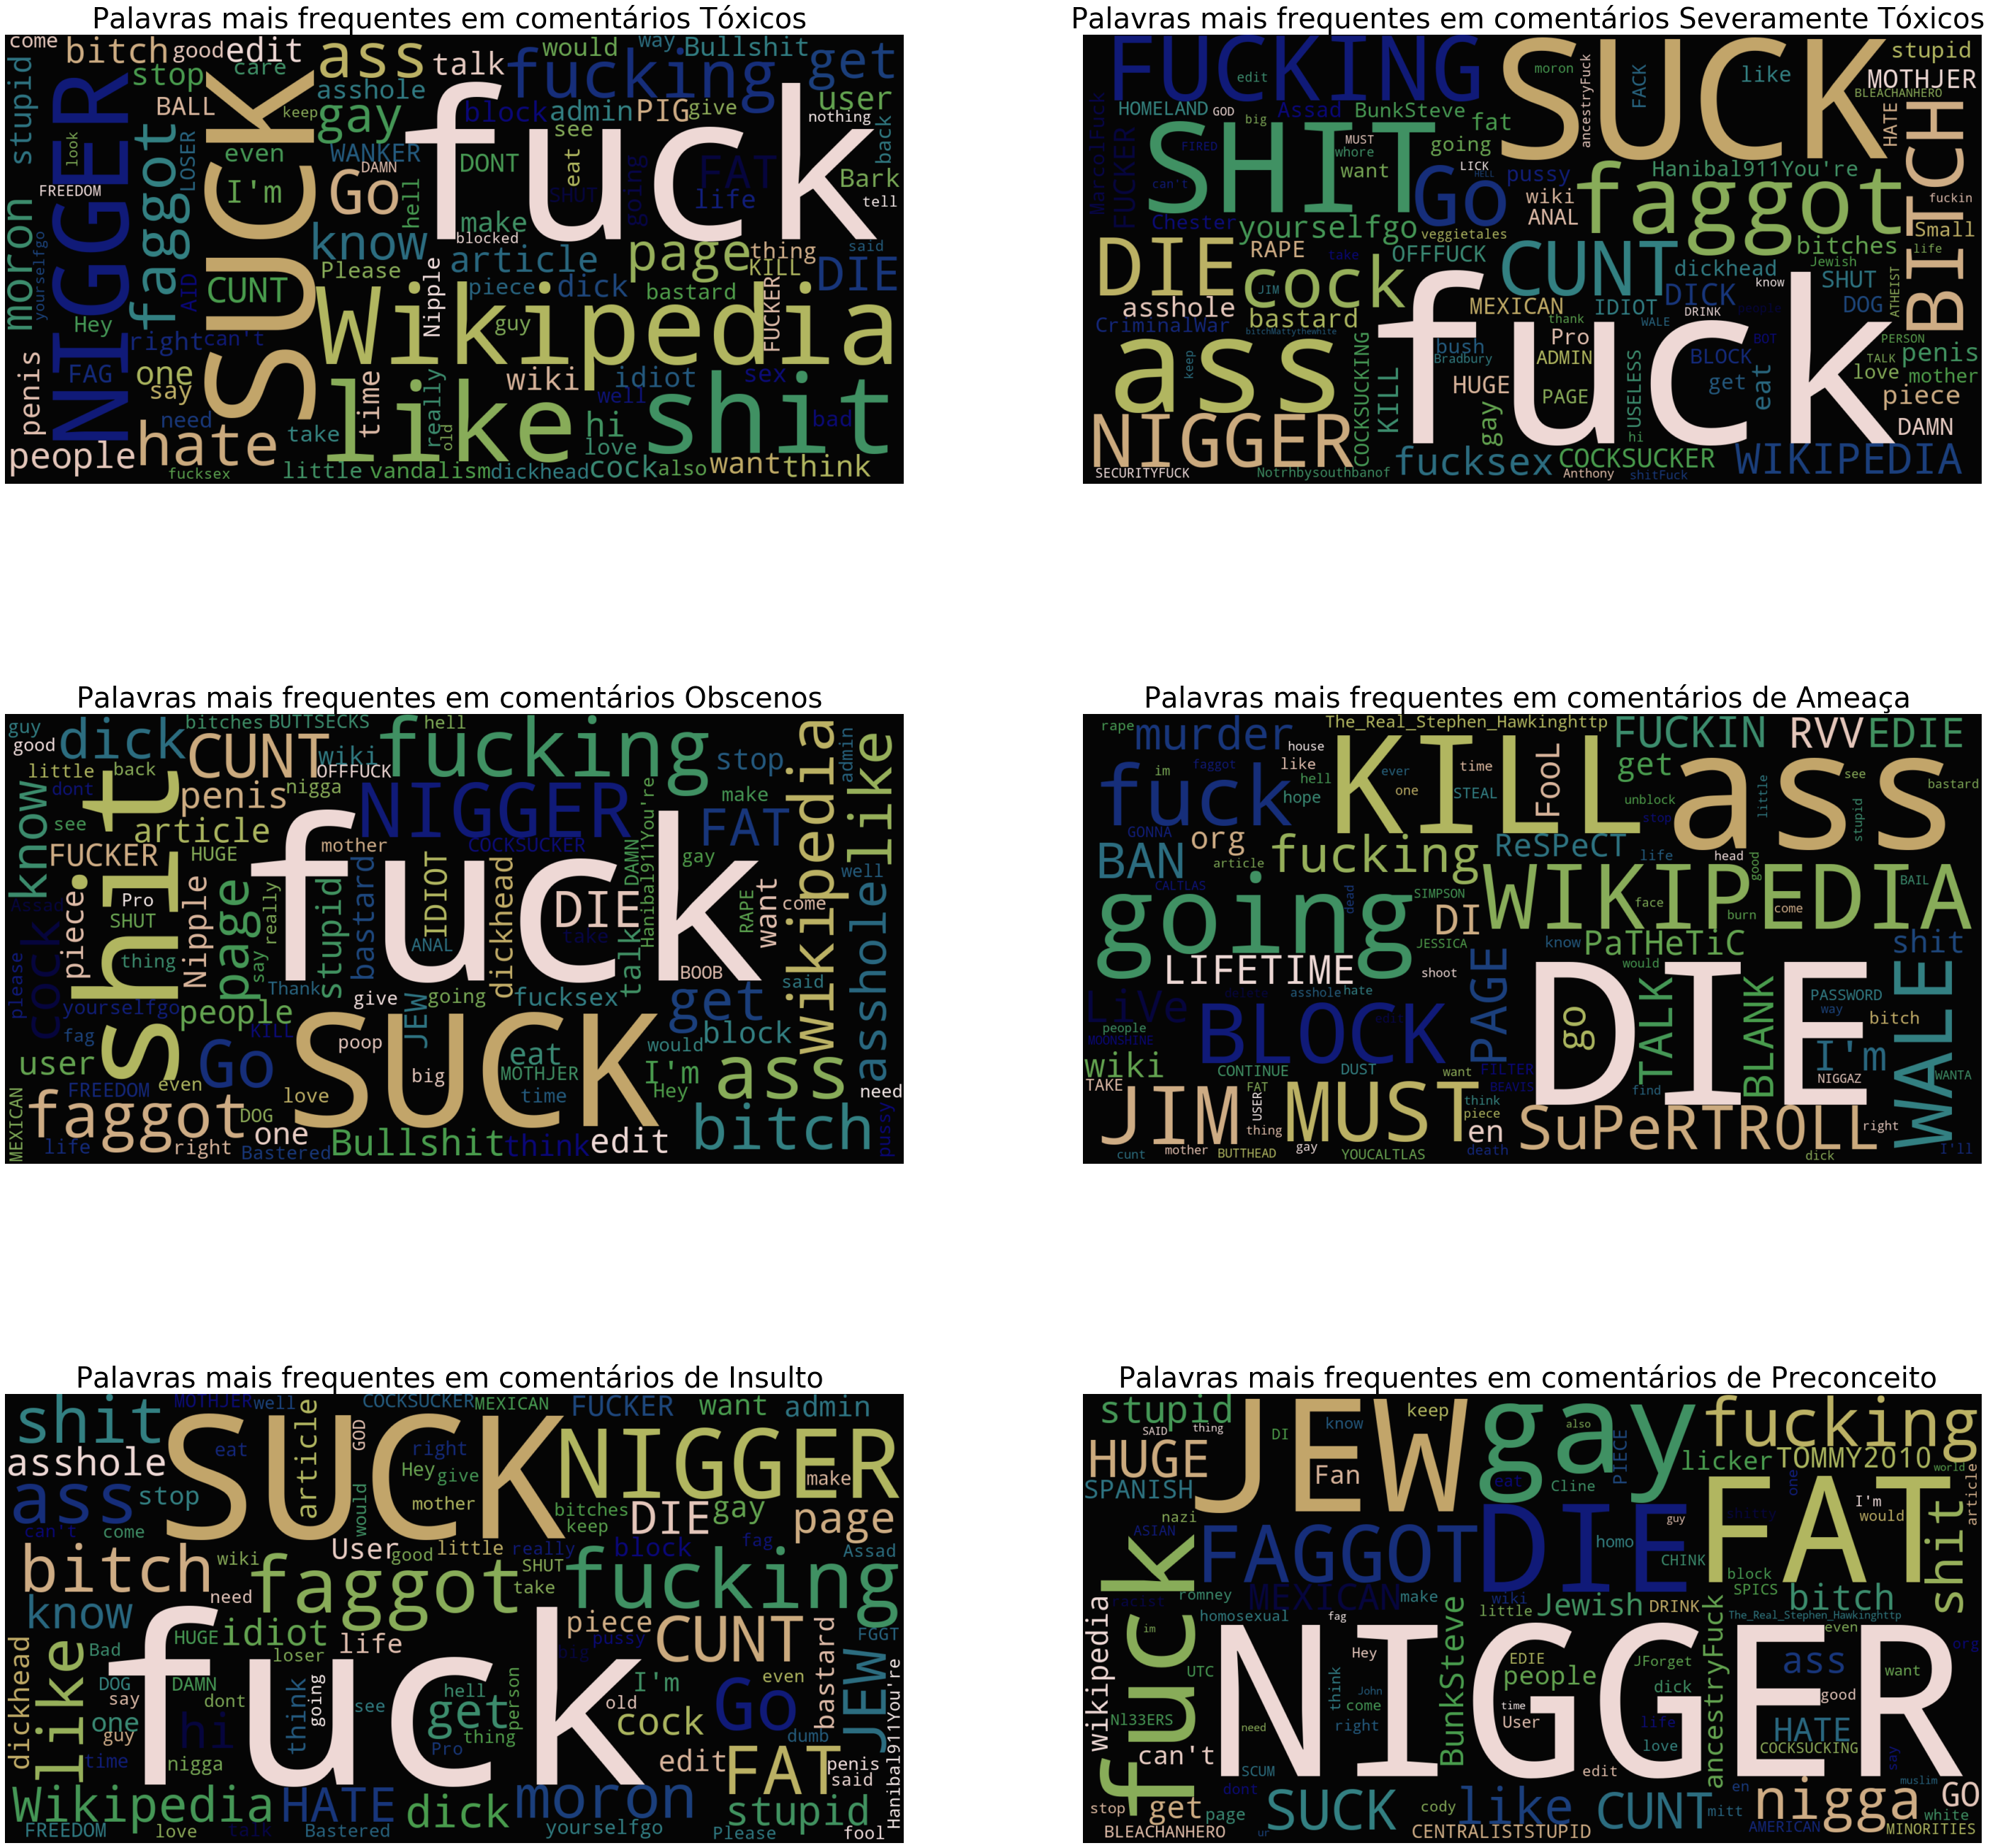

In [24]:


#wordcloud para comentários tóxicos
subset=dados_treino[dados_treino.toxic==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.figure(figsize = (50,50))
plt.subplot(321)
plt.axis("off")
plt.title("Palavras mais frequentes em comentários Tóxicos ", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98, interpolation="bilinear")

#wordcloud para comentários severamente tóxicos
plt.subplot(322)
subset=dados_treino[dados_treino.severe_toxic==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários Severamente Tóxicos ", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98, interpolation="bilinear")

#wordcloud para comentários obscenos
plt.subplot(323)
subset=dados_treino[dados_treino.obscene==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários Obscenos ", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98, interpolation="bilinear")

#wordcloud para comentários de ameaça
plt.subplot(324)
subset=dados_treino[dados_treino.threat==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários de Ameaça ", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98, interpolation="bilinear")


#wordcloud para comentários de insulto
plt.subplot(325)
subset=dados_treino[dados_treino.insult==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários de Insulto ", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98, interpolation="bilinear")



#wordcloud para comentários de Preconceito
plt.subplot(326)
subset=dados_treino[dados_treino.identity_hate==True]
text=subset.comment_text.values
wc= WordCloud(background_color="black",max_words=100, stopwords=stop,collocations=False,width=1600, height=800)
wc.generate(" ".join(text))
plt.axis("off")
plt.title("Palavras mais frequentes em comentários de Preconceito ", fontsize=40)
plt.imshow(wc.recolor(colormap= 'gist_earth' , random_state=244), alpha=0.98, interpolation="bilinear")





## Vetorizando nossos textos tratados

Após um breve pesquisa, concluímos que no problema com o qual estamos lidando o método de vetorização disponível pela biblioteca Sklearn mais adequado é o `TfidfVectorizer`

TF_IDF significa em tradução livre : Frequência do termo - Inverso da Frequência no Documento. Seu objetivo é definir o quão importante uma palavra é pro documento, enquanto leva em consideração sua relação com outros documentos de nosso corpus textual.

A lógica por tráz da classificação desse algorítmo é a seguinte:
Uma Palavra que aparece frequentemente em um documento possui mais relevância para esse documento, o que quer dizer que ele tem uma alta probabilidade de se tratar dessa palavra ou de algo sobre ela. Já uma palavra que aparece frequentemente em mais de um documento pode nos atrapalhar em achar o documento que desejamos no meio de vários; Por exemplo, se a palavra 'fuck' está na grande maioria dos comentários, ela acaba não sendo tão relevante na classificação desse comentário, uma palavra mais específica como 'nigger', teria um impacto maior na classificação, uma vez que ela é menos frequente e ao vermos ela temos quase que certeza absoluta que se trata de um comentário, por exemplo de preconceito.

O algorítmo atribui uma certa nota a cada palavra. Essa nota aumenta com cada aparição sua no documento, entretanto diminui com cada apariçnao sua em outros documentos


Texto inspirado em: https://towardsdatascience.com/tf-idf-explained-and-python-sklearn-implementation-b020c5e83275

In [77]:
cv = TfidfVectorizer(stop_words='english')
x_treinocv = cv.fit_transform(x_treino)
x_testecv = cv.fit_transform(x_teste)

In [26]:

#Para uma análise futura
#model_mnvb = MultinomialNB()
#model_mnvb.fit(x_treinocv,y_train.toxic.head(10))
#dados.loc[dados.toxic!=0,:]

## Aplicando modelo de predição junto com a acurácia obtida

Para uma primeira análise estamos um método conhecido como "Relevância Binária", ele basicamente trata cada 'Label' ou tipo de comentário como um problema separado de classificação, ou seja, a priório não estamos analisando nenhuma correlação entre os diversos labels, que por sinal existem. Tal análise virá em iterações futuras.

In [83]:
#Modelo: Regressão Logística
modelo_RL = LogisticRegression()
rotulos = ['obscene','insult','toxic','severe_toxic','identity_hate','threat']

for rotulo in rotulos:
    print('... Processando {}'.format(rotulo))
    y = y_treino[rotulo]
    modelo_RL.fit(x_treinocv, y)
    y_preve_X = modelo_RL.predict(x_treinocv)
    print('A acurácia do treino é {}'.format(accuracy_score(y, y_preve_X)))
    #teste_y_prob = modelo_RL.predict_proba(x_testecv)

... Processando obscene
A acurácia do treino é 0.9788307399214143
... Processando insult
A acurácia do treino é 0.9721189940528041
... Processando toxic
A acurácia do treino é 0.9602810034404747
... Processando severe_toxic
A acurácia do treino é 0.9909382030569465
... Processando identity_hate
A acurácia do treino é 0.9924861033646465
... Processando threat
A acurácia do treino é 0.9972676739507805
